In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
import math
from scipy import signal
from scipy.fft import fft, ifft
import soundfile as sf
from IPython.display import Audio

In [59]:
def simplePhaseVocoder(s, blockSize, hopSize, timeScale):
    numBlocks = int(len(s) / hopSize)
    numFreqs = int(blockSize / 2)
    
    outputBlockSize = int(blockSize * timeScale)
    outputHopSize = int(hopSize * timeScale)

    outputSize = int((numBlocks - 1) * outputHopSize + outputBlockSize)
    twoPi = 2 * np.pi
    
    output = np.zeros(outputSize)

    deltaPhis = np.zeros(numFreqs)
    phis = np.zeros(numFreqs)
    for k in range(numFreqs):
        deltaPhis[k] = (k / blockSize) * twoPi
    s = np.pad(s, (0, blockSize), 'constant')

    for i in range(numBlocks):
        inStart = i * hopSize
        inEnd = inStart + blockSize
        fftRes = fft(s[inStart:inEnd])[:numFreqs]
        fftMags = np.absolute(fftRes) / blockSize
        
        outStart = outputHopSize * i
        for j in range(outputHopSize):
            outIdx = outStart + j
            vals = fftMags[1:] * np.sin(phis[1:])
            output[outIdx] = np.sum(vals)
            phis += deltaPhis
            phis = (phis + np.pi) % twoPi - np.pi
    return output        


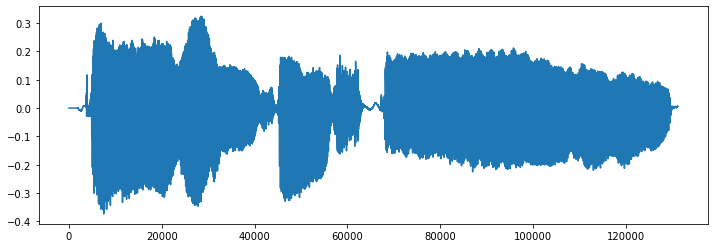

In [7]:
x, sr = sf.read('input/cathy.wav')

plt.rcParams["figure.figsize"] = (12,4)
plt.plot(x)


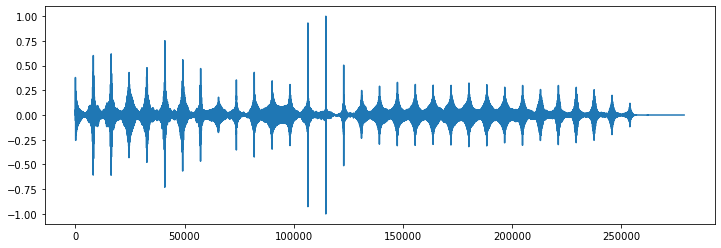

In [65]:
x, sr = sf.read('input/cathy.wav')
y = simplePhaseVocoder(x, 8192, 32, 2)
y = y / np.max(y)

plt.rcParams["figure.figsize"] = (12,4)
plt.plot(y)

output = 'output/cathy_2xLen_pv_noReassignment.wav'
sf.write(output, y, sr)
Audio(output)




In [66]:
def simplePhaseVocoderFreqReassignment(s, blockSize, hopSize, timeScale):
    numBlocks = int(len(s) / hopSize)
    numFreqs = int(blockSize / 2)
    
    outputBlockSize = int(blockSize * timeScale)
    outputHopSize = int(hopSize * timeScale)

    outputSize = int((numBlocks - 1) * outputHopSize + outputBlockSize)
    twoPi = 2 * np.pi
    
    output = np.zeros(outputSize)
    prevDeltaPhis = np.zeros(numFreqs)
    deltaPhis = np.zeros(numFreqs)
    binDeltaPhis = np.zeros(numFreqs)
    for k in range(numFreqs):
        prevDeltaPhis[k] = (k / blockSize) * twoPi
        binDeltaPhis[k] = (k * hopSize / blockSize) * twoPi
    
    phis = np.zeros(numFreqs)
    s = np.pad(s, (0, blockSize), 'constant')
    
    fftMags = np.zeros((numBlocks, numFreqs))
    fftPhis = np.zeros((numBlocks, numFreqs))

    for i in range(numBlocks):
        inStart = i * hopSize
        inEnd = inStart + blockSize
        fftRes = fft(s[inStart:inEnd])[:numFreqs]
        fftMags[i] = np.absolute(fftRes) / blockSize
        fftPhis[i] = np.angle(fftRes)

    for i in range(numBlocks - 1):
        phiDiffs = fftPhis[i+1] - fftPhis[i] - binDeltaPhis
        phiDiffs = (phiDiffs + np.pi) % (2 * np.pi) - np.pi
        deltaPhis = (binDeltaPhis + phiDiffs) / hopSize
                
        outStart = outputHopSize * i
        for j in range(outputHopSize):
            a = j / outputHopSize
            outIdx = outStart + j
            vals = fftMags[i] * np.sin(phis)
            output[outIdx] = np.sum(vals)
            phis += prevDeltaPhis * (1-a) + deltaPhis * a
            phis = (phis + np.pi) % (2 * np.pi) - np.pi

        prevDeltaPhis = deltaPhis

    return output


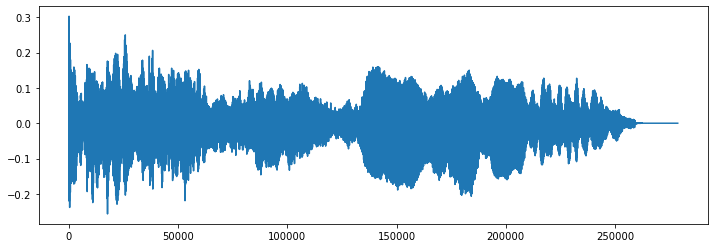

In [67]:
x, sr = sf.read('input/cathy.wav')
y = simplePhaseVocoderFreqReassignment(x, 8192, 32, 2)

plt.rcParams["figure.figsize"] = (12,4)
plt.plot(y)

output = 'output/cathy_2xLen_pv.wav'
sf.write(output, y, sr)
Audio(output)



In [69]:
def simplePhaseVocoderFreqReassignmentWindowing(s, blockSize, hopSize, timeScale):
    numBlocks = int(len(s) / hopSize)
    numFreqs = int(blockSize / 2)
    
    outputBlockSize = int(blockSize * timeScale)
    outputHopSize = int(hopSize * timeScale)

    outputSize = int((numBlocks - 1) * outputHopSize + outputBlockSize)
    twoPi = 2 * np.pi
    
    output = np.zeros(outputSize)
    prevDeltaPhis = np.zeros(numFreqs)
    deltaPhis = np.zeros(numFreqs)
    binDeltaPhis = np.zeros(numFreqs)
    for k in range(numFreqs):
        prevDeltaPhis[k] = (k / blockSize) * twoPi
        binDeltaPhis[k] = (k * hopSize / blockSize) * twoPi
    
    phis = np.zeros(numFreqs)
    s = np.pad(s, (0, blockSize), 'constant')
    
    fftMags = np.zeros((numBlocks, numFreqs))
    fftPhis = np.zeros((numBlocks, numFreqs))
    hanWin = np.hanning(blockSize)

    for i in range(numBlocks):
        inStart = i * hopSize
        inEnd = inStart + blockSize
        fftRes = fft(s[inStart:inEnd] * hanWin)[:numFreqs]
        fftMags[i] = np.absolute(fftRes) / blockSize
        fftPhis[i] = np.angle(fftRes)

    for i in range(numBlocks - 1):
        phiDiffs = fftPhis[i+1] - fftPhis[i] - binDeltaPhis
        phiDiffs = (phiDiffs + np.pi) % (2 * np.pi) - np.pi
        deltaPhis = (binDeltaPhis + phiDiffs) / hopSize
                
        outStart = outputHopSize * i
        for j in range(outputHopSize):
            a = j / outputHopSize
            outIdx = outStart + j
            vals = fftMags[i] * np.sin(phis)
            output[outIdx] = np.sum(vals)
            phis += prevDeltaPhis * (1-a) + deltaPhis * a
            phis = (phis + np.pi) % (2 * np.pi) - np.pi

        prevDeltaPhis = deltaPhis

    return output


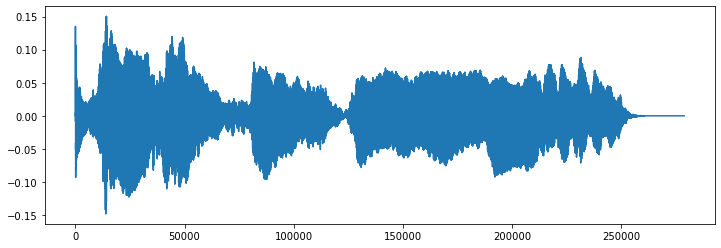

In [70]:
x, sr = sf.read('input/cathy.wav')
y = simplePhaseVocoderFreqReassignmentWindowing(x, 8192, 32, 2)

plt.rcParams["figure.figsize"] = (12,4)
plt.plot(y)

output = 'output/cathy_2xLen_pv_freq_win.wav'
sf.write(output, y, sr)
Audio(output)

